In [17]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

# Import data

In [18]:
variable = {'phF': 0, 'MF': 1}['phF'] # TODO: for now just classify one variable

In [19]:
train_path = './Output/train'
test_path = './Output/test'

In [20]:
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(train_path) if p[:14] == 'feature_vector']), \
                             *np.load(train_path + '/feature_vector0.npy').shape
N_test = sum([1 for p in os.listdir(test_path) if p[:14] == 'feature_vector'])

print(f'Training set: {N}')
print(f'Test set: {N_test}')

Training set: 4213
Test set: 399


# Define data generator

In [21]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # TODO: int for non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            X[i, ] = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[variable] # TODO: for now just one variable

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [22]:
UPSAMPLING_STRATEGY = 'nothing' # ['repeat', 'nothing']

In [23]:
def check_imbalance(path_to_labels, indices):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0] # TODO: for now just one variable
    negatives = np.where(y[:, variable] == 0)[0] # TODO: for now just one variable

    return np.array(indices)[positives], np.array(indices)[negatives]


# validation set
positives, negatives = check_imbalance(test_path, np.arange(N_test)) # TODO: use test set to avoid mixing
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

# training set
positives, negatives = check_imbalance(train_path, np.arange(N))
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

sample_weight = len(negatives) / len(positives) # for weighted cross-entropy

# upsampling training set
if UPSAMPLING_STRATEGY == 'repeat':
    upsampled_indices = np.random.choice(negatives, size=(len(positives) - len(negatives)), replace=True) # with replacement
    upsampled_indices = np.append(upsampled_indices, np.arange(N))
    train_indices = np.append(positives, negatives) # update

    positives, negatives = check_imbalance(train_path, upsampled_indices)
    print(f'train_set (upsampled): (+: {len(positives)}, -: {len(negatives)})')
if UPSAMPLING_STRATEGY == 'nothing':
    pass

train_set: (+: 284, -: 115)
train_set: (+: 3142, -: 1071)


# CNN

Data generators

In [24]:
training_batch_generator = DataGenerator(data_path=train_path, indices_dataset=np.arange(N), batch_size=128)
validation_batch_generator = DataGenerator(data_path=test_path, indices_dataset=np.arange(N_test), batch_size=32) # TODO: use test set to avoid mixing

Model

In [25]:
# wrapper functions
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits

class accuracy_with_logits(tf.keras.metrics.Accuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        #y_pred = (tf.sign(y_pred + K.epsilon(), 1) + 1.0) / 2 # == int(y_pred > 0)
        return super(accuracy_with_logits, self).update_state(y_true, y_pred, sample_weight)

class recall_with_logits(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        #y_pred = (tf.sign(y_pred + K.epsilon(), 1) + 1.0) / 2 # == int(y_pred > 0)
        return super(recall_with_logits, self).update_state(y_true, y_pred, sample_weight)

class precision_with_logits(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        #y_pred = (tf.sign(y_pred + K.epsilon(), 1) + 1.0) / 2 # == int(y_pred > 0)
        return super(precision_with_logits, self).update_state(y_true, y_pred, sample_weight)

In [26]:
model = models.Sequential(name='custom_CNN')

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(370, 100, 30), padding='same', name='conv1-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1-2'))
model.add(BatchNormalization(name='batch_norm1')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool1'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2-2'))
model.add(BatchNormalization(name='batch_norm2')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool2'))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-1'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-2'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv3-3'))
model.add(BatchNormalization(name='batch_norm3')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool3'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv4-3'))
model.add(BatchNormalization(name='batch_norm4')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool4'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv5-3'))
model.add(BatchNormalization(name='batch_norm5')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool5'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-1'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-2'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv6-3'))
model.add(BatchNormalization(name='batch_norm6')) # try for incr. stability
model.add(MaxPool2D(strides=(2, 2), name='pool6'))

model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense1'))
#model.add(Dropout(0.4, name='dropout1'))
model.add(Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2', name='dense2'))
#model.add(Dropout(0.3, name='dropout2'))
model.add(Dense(1, kernel_regularizer='l2', name='dense3'))

#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy(sample_weight), metrics=[accuracy_with_logits(),
                                                                                              recall_with_logits(),
                                                                                              precision_with_logits()])

model.summary()

Model: "custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1-1 (Conv2D)             (None, 370, 100, 16)      4336      
_________________________________________________________________
conv1-2 (Conv2D)             (None, 370, 100, 16)      2320      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 370, 100, 16)      64        
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 185, 50, 16)       0         
_________________________________________________________________
conv2-1 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
conv2-2 (Conv2D)             (None, 185, 50, 16)       2320      
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 185, 50, 16)       6

Training

In [27]:
%%time
# save best performing model
checkpoint_path = './temp/checkpoint_model'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            save_best_only=True)

# train
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=100,
                              callbacks=[model_checkpoint_callback])

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
32/32 [==============================] - 62s 2s/step - loss: 1.1095 - accuracy: 0.3201 - recall_with_logits_1: 0.1159 - precision_with_logits_1: 0.7950 - val_loss: 1.1100 - val_accuracy: 0.2839 - val_recall_with_logits_1: 0.0000e+00 - val_precision_with_logits_1: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 60s 2s/step - loss: 1.0954 - accuracy: 0.3833 - recall_with_logits_1: 0.2452 - precision_with_logits_1: 0.7730 - val_loss: 1.1046 - val_accuracy: 0.2839 - val_recall_with_logits_1: 0.0000e+00 - val_precision_with_logits_1: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 61s 2s/step - loss: 1.0863 - accuracy: 0.4534 - recall_with_logits_1: 0.3627 - precision_with_logits_1: 0.7927 - val_loss: 1.0975 - val_accuracy: 0.2786 - val_recall_with_logits_1: 0.0000e+00 - val_precision_with_logits_1: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 60s 2s/step - loss: 1.0784 - accuracy: 0.5032 - recall_with_logits_1: 0.4432 - precisi

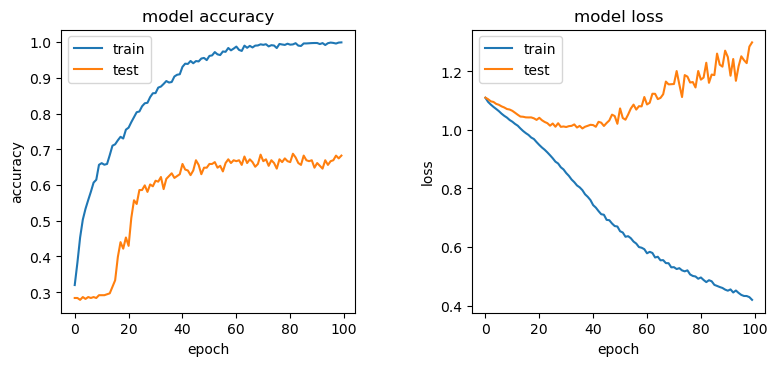

In [28]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# metric
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Evaluation

In [29]:
# load best performing model
model.load_weights(checkpoint_path)

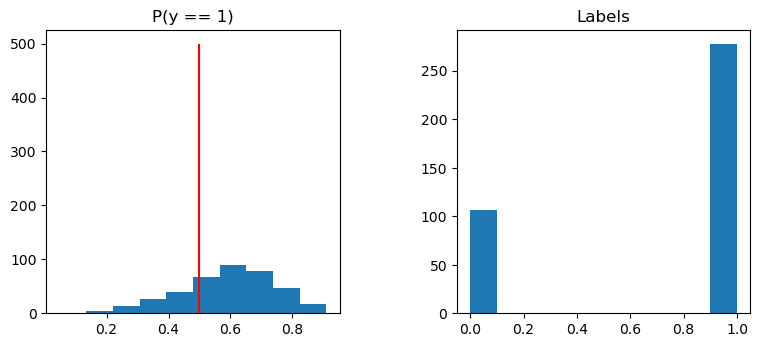

In [30]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [31]:
# load test data
N_test = sum([1 for p in os.listdir(test_path) if p[:14] == 'feature_vector'])
print(f'Test set: {N_test}')

test_batch_generator = DataGenerator(data_path=test_path, indices_dataset=[i for i in range(N_test)], batch_size=1)
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 399


accuracy: 0.631578947368421
balanced accuracy: 0.5419779546846295
f1 (weighted): 0.628039117094745
recall (weighted): 0.631578947368421
precision (weighted): 0.6248501168920775


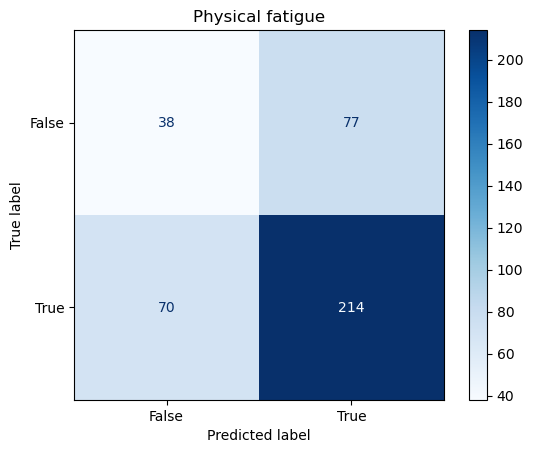

In [32]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')